In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def K(x, sigma=1, dim=7):
    w = np.linalg.norm(x, ord=2)
    return np.exp(-w ** 2 / 2 / sigma**2) / (2 * np.pi * sigma**2)**(dim/2)

In [3]:
dataset = pd.read_csv('water_potability.csv')
for col in dataset.columns[:9]:
    dataset[col] = (dataset[col] - dataset[col].mean()) / dataset[col].std()
dataset_dna = dataset.dropna()
dataset_na = dataset[dataset.isna().any(axis=1)]

In [4]:
import xgboost
model = xgboost.XGBRegressor()
model = model.fit(dataset.drop('Potability', axis=1), dataset['Potability'])

In [5]:
dataset_dna['pred'] = model.predict(dataset_dna.drop('Potability', axis=1))

In [6]:
print(((dataset_dna['Potability'] - dataset_dna['pred'])**2).mean())

0.021644594536688017


In [7]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dataset_dna, test_size=0.05, random_state=42)

In [8]:
def local_inference(target, labeled_set, unlabeled_set, h):
    feature_names = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
    target_X = target[feature_names]

    X = np.concatenate([
        np.ones((1, len(labeled_set))),
        labeled_set[feature_names].sub(target_X.values, axis=1).T.values
    ])
    Y = labeled_set['Potability'].values.reshape(-1, 1)
    Y_F = labeled_set['pred'].values.reshape(-1, 1)
    W = np.array([K(x[1:]/h) for x in X.T])

    tilde_X = np.concatenate([
        np.ones((1, len(unlabeled_set))),
        unlabeled_set[feature_names].sub(target_X.values, axis=1).T.values
    ])
    tilde_Y_F = unlabeled_set['pred'].values.reshape(-1, 1)
    tilde_W = np.array([K(x[1:]/h) for x in tilde_X.T])
    
    beta = np.linalg.inv((X * W) @ X.T) @ (X * W) @ Y
    inference = beta[0]

    beta_ppi = np.linalg.inv((tilde_X * tilde_W) @ tilde_X.T) @ (tilde_X * tilde_W) @ tilde_Y_F - \
               np.linalg.inv((X * W) @ X.T) @ (X * W) @ (Y_F - Y)
    inference_ppi = beta_ppi[0]
    
    return (inference[0], inference_ppi[0], target['Potability'])

In [9]:
from tqdm import tqdm
error_df = pd.DataFrame(index=np.arange(10100), columns=['id', 'inference', 'inference_ppi', 'true'])
for i in tqdm(test_set.index):
    target = test_set.loc[i]
    for j in range(100):
        unlabel_set, label_set = train_test_split(train_set.sample(1100, random_state=43+j), test_size=0.0909090909, random_state=42+j)
        inference, inference_ppi, true = local_inference(target, label_set, unlabel_set, 0.5)
        error_df.loc[i*100+j] = [i, inference, inference_ppi, true]

error_df = error_df.dropna().reset_index(drop=True)
error_df['infer_y'] = (error_df['inference'] > 0.5).astype(int)
error_df['infer_ppi_y'] = (error_df['inference_ppi'] > 0.5).astype(int)
record_df = pd.DataFrame(index=np.arange(101), columns=['id', 'acc', 'acc_ppi', 'error', 'error_ppi', 'std', 'std_ppi'])
test_idx = error_df['id'].unique()
for i in range(101):
    name = test_idx[i]
    tmp = error_df.query('id == @name')
    acc = (tmp['true'] == tmp['infer_y']).mean()
    acc_ppi = (tmp['true'] == tmp['infer_ppi_y']).mean()
    error = (tmp['true'] - tmp['infer_y']).mean()
    error_ppi = (tmp['true'] - tmp['infer_ppi_y']).mean()
    std = (tmp['infer_y']).std()
    std_ppi = (tmp['infer_ppi_y']).std()
    record_df.loc[i] = [name, acc, acc_ppi, error, error_ppi, std, std_ppi]
record_df['ppi_ratio']  = (record_df['std'] - record_df['std_ppi']) / record_df['std_ppi']
record_df['acc_ratio']  = (record_df['acc'] - record_df['acc_ppi']) / record_df['acc_ppi']
print((record_df['ppi_ratio'] < 1).sum(), (record_df['ppi_ratio'] > 1).sum())
print((record_df['acc_ratio'] < 1).sum(), (record_df['acc_ratio'] > 1).sum())
print(record_df['ppi_ratio'].mean(), record_df['acc_ratio'].mean())

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [02:08<00:00,  1.27s/it]


101 0
93 8
0.12954864400585805 0.1374562004025216


101 0
101 0
0.0493087329487553 0.030198019801980197


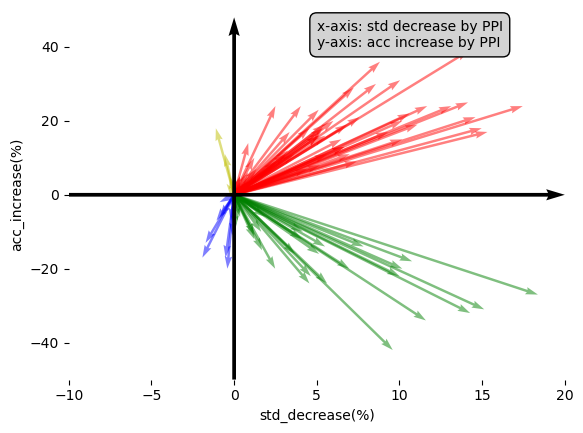

In [10]:
record_df['ppi_ratio']  = (record_df['std'] - record_df['std_ppi'])# / record_df['std_ppi']
record_df['acc_ratio']  = (record_df['acc_ppi'] - record_df['acc']) #/ record_df['acc_ppi']
print((record_df['ppi_ratio'] < 1).sum(), (record_df['ppi_ratio'] > 1).sum())
print((record_df['acc_ratio'] < 1).sum(), (record_df['acc_ratio'] > 1).sum())
print(record_df['ppi_ratio'].mean(), record_df['acc_ratio'].mean())

fig, ax = plt.subplots()
for i in range(101):
    x, y = record_df.loc[i, ['ppi_ratio', 'acc_ratio']]
    x *= 100
    y *= 100
    if x > 0 and y > 0:
        # ax.arrow(0,0,x,y,head_width=0.01, head_length=0.02, fc='r', ec='r', alpha=0.5)
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='r', alpha=0.5, linewidths=0.5, width=0.005)
    if x < 0 and y < 0:
        # ax.arrow(0,0,x,y,head_width=0.01, head_length=0.02, fc='b', ec='b', alpha=0.5)
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='b', alpha=0.5, linewidths=0.5, width=0.005)
    if x > 0 and y < 0:
        # ax.arrow(0,0,x,y,head_width=0.01, head_length=0.02, fc='g', ec='g', alpha=0.5)
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='g', alpha=0.5, linewidths=0.5, width=0.005)
    if x < 0 and y > 0:
        # ax.arrow(0,0,x,y,head_width=0.01, head_length=0.02, fc='y', ec='y', alpha=0.5)
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='y', alpha=0.5, linewidths=0.5, width=0.005)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.quiver(0, -50, 0, 98, angles='xy', scale_units='xy', scale=1)
plt.quiver(-80, 0, 100, 0, angles='xy', scale_units='xy', scale=1)

plt.annotate('x-axis: std decrease by PPI\ny-axis: acc increase by PPI', xy=(5, 40),bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="lightgray"))

plt.xlim(-10, 20)
plt.ylim(-50, 50)
plt.xlabel('std_decrease(%)')
plt.ylabel('acc_increase(%)')
plt.savefig('water_quality.png')

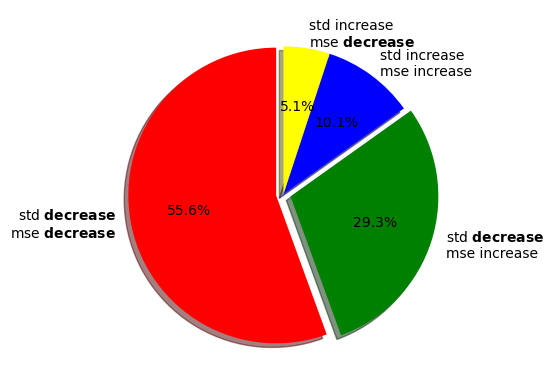

In [11]:
red, blue, green, yellow = 0, 0, 0, 0
for i in range(101):
    x, y = record_df.loc[i, ['ppi_ratio', 'acc_ratio']]
    if x > 0 and y > 0:
        red += 1
    if x < 0 and y < 0:
        blue += 1
    if x > 0 and y < 0:
        green += 1
    if x < 0 and y > 0:
        yellow += 1

labels = [
    'std $\mathbf{decrease}$\nmse $\mathbf{decrease}$',
    'std $\mathbf{decrease}$\nmse increase',
    'std increase\nmse increase',
    'std increase\nmse $\mathbf{decrease}$'
]


plt.pie([red, green, blue, yellow], colors=['red', 'green', 'blue', 'yellow'], explode=(0.05, 0.05, 0, 0), autopct='%1.1f%%', shadow=True, startangle=90, labels=labels)

# plt.show()
plt.savefig('water quality pie.png')


In [12]:
from tqdm import tqdm
error_df = pd.DataFrame(index=np.arange(10100), columns=['id', 'inference', 'inference_ppi', 'true'])
for i in tqdm(test_set.index):
    target = test_set.loc[i]
    for j in range(100):
        unlabel_set, label_set = train_test_split(train_set.sample(1100, random_state=43+j), test_size=0.0909090909, random_state=42+j)
        inference, inference_ppi, true = local_inference(target, label_set, unlabel_set, 0.6)
        error_df.loc[i*100+j] = [i, inference, inference_ppi, true]

error_df = error_df.dropna().reset_index(drop=True)
error_df['infer_y'] = (error_df['inference'] > 0.5).astype(int)
error_df['infer_ppi_y'] = (error_df['inference_ppi'] > 0.5).astype(int)
record_df = pd.DataFrame(index=np.arange(101), columns=['id', 'acc', 'acc_ppi', 'error', 'error_ppi', 'std', 'std_ppi'])
test_idx = error_df['id'].unique()
for i in range(101):
    name = test_idx[i]
    tmp = error_df.query('id == @name')
    acc = (tmp['true'] == tmp['infer_y']).mean()
    acc_ppi = (tmp['true'] == tmp['infer_ppi_y']).mean()
    error = (tmp['true'] - tmp['infer_y']).mean()
    error_ppi = (tmp['true'] - tmp['infer_ppi_y']).mean()
    std = (tmp['infer_y']).std()
    std_ppi = (tmp['infer_ppi_y']).std()
    record_df.loc[i] = [name, acc, acc_ppi, error, error_ppi, std, std_ppi]
record_df['ppi_ratio']  = record_df['std'] / record_df['std_ppi']
record_df['acc_ratio']  = record_df['acc'] / record_df['acc_ppi']
print((record_df['ppi_ratio'] < 1).sum(), (record_df['ppi_ratio'] > 1).sum())
print((record_df['acc_ratio'] < 1).sum(), (record_df['acc_ratio'] > 1).sum())

100%|██████████| 101/101 [01:53<00:00,  1.12s/it]


In [13]:
from tqdm import tqdm
error_df = pd.DataFrame(index=np.arange(10100), columns=['id', 'inference', 'inference_ppi', 'true'])
for i in tqdm(test_set.index):
    target = test_set.loc[i]
    for j in range(100):
        unlabel_set, label_set = train_test_split(train_set.sample(1100, random_state=43+j), test_size=0.0909090909, random_state=42+j)
        inference, inference_ppi, true = local_inference(target, label_set, unlabel_set, 0.7)
        error_df.loc[i*100+j] = [i, inference, inference_ppi, true]

error_df = error_df.dropna().reset_index(drop=True)
error_df['infer_y'] = (error_df['inference'] > 0.5).astype(int)
error_df['infer_ppi_y'] = (error_df['inference_ppi'] > 0.5).astype(int)
record_df = pd.DataFrame(index=np.arange(101), columns=['id', 'acc', 'acc_ppi', 'error', 'error_ppi', 'std', 'std_ppi'])
test_idx = error_df['id'].unique()
for i in range(101):
    name = test_idx[i]
    tmp = error_df.query('id == @name')
    acc = (tmp['true'] == tmp['infer_y']).mean()
    acc_ppi = (tmp['true'] == tmp['infer_ppi_y']).mean()
    error = (tmp['true'] - tmp['infer_y']).mean()
    error_ppi = (tmp['true'] - tmp['infer_ppi_y']).mean()
    std = (tmp['infer_y']).std()
    std_ppi = (tmp['infer_ppi_y']).std()
    record_df.loc[i] = [name, acc, acc_ppi, error, error_ppi, std, std_ppi]
record_df['ppi_ratio']  = record_df['std'] / record_df['std_ppi']
record_df['acc_ratio']  = record_df['acc'] / record_df['acc_ppi']
print((record_df['ppi_ratio'] < 1).sum(), (record_df['ppi_ratio'] > 1).sum())
print((record_df['acc_ratio'] < 1).sum(), (record_df['acc_ratio'] > 1).sum())

100%|██████████| 101/101 [01:52<00:00,  1.11s/it]


51 48
48 51


In [14]:
from tqdm import tqdm
error_df = pd.DataFrame(index=np.arange(10100), columns=['id', 'inference', 'inference_ppi', 'true'])
for i in tqdm(test_set.index):
    target = test_set.loc[i]
    for j in range(100):
        unlabel_set, label_set = train_test_split(train_set.sample(1100, random_state=43+j), test_size=0.05, random_state=42+j)
        inference, inference_ppi, true = local_inference(target, label_set, unlabel_set, 0.8)
        error_df.loc[i*100+j] = [i, inference, inference_ppi, true]

error_df = error_df.dropna().reset_index(drop=True)
error_df['infer_y'] = (error_df['inference'] > 0.5).astype(int)
error_df['infer_ppi_y'] = (error_df['inference_ppi'] > 0.5).astype(int)
record_df = pd.DataFrame(index=np.arange(101), columns=['id', 'acc', 'acc_ppi', 'error', 'error_ppi', 'std', 'std_ppi'])
test_idx = error_df['id'].unique()
for i in range(101):
    name = test_idx[i]
    tmp = error_df.query('id == @name')
    acc = (tmp['true'] == tmp['infer_y']).mean()
    acc_ppi = (tmp['true'] == tmp['infer_ppi_y']).mean()
    error = (tmp['true'] - tmp['infer_y']).mean()
    error_ppi = (tmp['true'] - tmp['infer_ppi_y']).mean()
    std = (tmp['infer_y']).std()
    std_ppi = (tmp['infer_ppi_y']).std()
    record_df.loc[i] = [name, acc, acc_ppi, error, error_ppi, std, std_ppi]
record_df['ppi_ratio']  = record_df['std'] / record_df['std_ppi']
record_df['acc_ratio']  = record_df['acc'] / record_df['acc_ppi']
print((record_df['ppi_ratio'] < 1).sum(), (record_df['ppi_ratio'] > 1).sum())
print((record_df['acc_ratio'] < 1).sum(), (record_df['acc_ratio'] > 1).sum())
print(record_df['ppi_ratio'].mean(), record_df['acc_ratio'].mean())

100%|██████████| 101/101 [01:52<00:00,  1.12s/it]


40 53
42 47


In [15]:
record_df['ppi_ratio'].mean(), record_df['acc_ratio'].mean()

(1.0037964763468255, 1.017601549483737)